# Sales forecast of a pesticide type

### Hypotheses

The price of a pesticide type depends on the other pesticides too.

2 models has been built to test the hypotheses and forecast
- Linear Regression
- Artificial neural network

In [267]:
#conda install -c intel scikit-learn

In [268]:
#conda install -c conda-forge pycountry

In [269]:
#conda install -c conda-forge tensorflow --yes

In [270]:
#conda install -c conda-forge keras --yes

In [219]:
import pandas as pd
import numpy as np
import pycountry
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import statsmodels.api as sm
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import pickle

In [220]:
df = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/data-science-in-agriculture-prognostication-using-by-neural-network/aei_fm_salpest09__custom_1145078_20210714_093842.sdmx.csv')

In [221]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATAFLOW     1645 non-null   object 
 1   LAST UPDATE  1645 non-null   object 
 2   freq         1645 non-null   object 
 3   pesticid     1645 non-null   object 
 4   unit         1645 non-null   object 
 5   geo          1645 non-null   object 
 6   TIME_PERIOD  1645 non-null   int64  
 7   OBS_VALUE    1527 non-null   float64
 8   OBS_FLAG     496 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 115.8+ KB


In [222]:
col = df.columns
col

Index(['DATAFLOW', 'LAST UPDATE', 'freq', 'pesticid', 'unit', 'geo',
       'TIME_PERIOD', 'OBS_VALUE', 'OBS_FLAG'],
      dtype='object')

In [223]:
df = df[["pesticid","geo","TIME_PERIOD","OBS_VALUE"]]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1645 entries, 0 to 1644
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   pesticid     1645 non-null   object 
 1   geo          1645 non-null   object 
 2   TIME_PERIOD  1645 non-null   int64  
 3   OBS_VALUE    1527 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 51.5+ KB


Pesticid - pesticide code

geo - country code

TIME_PERIOD - year

OBS_VALUE - volume of sales in KG

In [224]:
col = ['pesticid','geo']
df.loc[:,col] = df[col].astype('category')
df[col].describe()

,pesticid,geo
count,1645,1645
unique,6,32
top,F,AT
freq,277,54


In [225]:
df['pesticid'].unique()

['F', 'H', 'I', 'M', 'PGR', 'ZR']
Categories (6, object): ['F', 'H', 'I', 'M', 'PGR', 'ZR']

In [226]:
df['geo'].cat.categories

Index(['AT', 'BE', 'BG', 'CH', 'CY', 'CZ', 'DE', 'DK', 'EE', 'EL', 'ES', 'FI',
       'FR', 'HR', 'HU', 'IE', 'IS', 'IT', 'LT', 'LU', 'LV', 'MT', 'NL', 'NO',
       'PL', 'PT', 'RO', 'SE', 'SI', 'SK', 'TR', 'UK'],
      dtype='object')

In [227]:
df.loc[:,'geo'] = df['geo'].cat.add_categories(['GB','GR'])

In [228]:
pd.options.mode.chained_assignment = None
mask = df['geo'] == 'UK'
df.loc[mask,'geo'] = 'GB'

In [229]:
mask = df['geo'] == 'EL'
df.loc[mask,'geo'] = 'GR'
df

,pesticid,geo,TIME_PERIOD,OBS_VALUE
0,F,AT,2011,"1,544,218.00"
1,F,AT,2012,"1,634,371.00"
2,F,AT,2013,"1,492,799.00"
3,F,AT,2014,"1,641,055.00"
4,F,AT,2015,"2,130,973.00"
...,...,...,...,...
1640,ZR,GB,2015,NaN
1641,ZR,GB,2016,NaN
1642,ZR,GB,2017,"270,493.00"
1643,ZR,GB,2018,NaN


In [230]:
country_list = [i.alpha_2 for i in list(pycountry.countries)]

def country_flag(df):
    if (df['geo'] in country_list):
        return pycountry.countries.get(alpha_2 = df['geo']).name
    else:
        print(df['geo'])
        return "Invalid Code"

df['country_name'] = df.apply(country_flag, axis = 1)

In [231]:
df

,pesticid,geo,TIME_PERIOD,OBS_VALUE,country_name
0,F,AT,2011,"1,544,218.00",Austria
1,F,AT,2012,"1,634,371.00",Austria
2,F,AT,2013,"1,492,799.00",Austria
3,F,AT,2014,"1,641,055.00",Austria
4,F,AT,2015,"2,130,973.00",Austria
...,...,...,...,...,...
1640,ZR,GB,2015,NaN,United Kingdom
1641,ZR,GB,2016,NaN,United Kingdom
1642,ZR,GB,2017,"270,493.00",United Kingdom
1643,ZR,GB,2018,NaN,United Kingdom


create a dictionary where key is pesticide code and value is pesticide name

In [232]:
pes = {'F': 'Fungicides and bactericides',
      'H': 'Herbicides, haulm destructors and moss killers',
      'I': 'Insecticides and acaricides',
      'M': 'Molluscicides',
      'PGR': 'Plant growth regulators',
      'ZR': 'Other plant protection products'}

In [233]:
df['pesticid_name'] = df['pesticid'].map(pes)
df['pesticid_name'] = df['pesticid_name'].astype('category')
df

,pesticid,geo,TIME_PERIOD,OBS_VALUE,country_name,pesticid_name
0,F,AT,2011,"1,544,218.00",Austria,Fungicides and bactericides
1,F,AT,2012,"1,634,371.00",Austria,Fungicides and bactericides
2,F,AT,2013,"1,492,799.00",Austria,Fungicides and bactericides
3,F,AT,2014,"1,641,055.00",Austria,Fungicides and bactericides
4,F,AT,2015,"2,130,973.00",Austria,Fungicides and bactericides
...,...,...,...,...,...,...
1640,ZR,GB,2015,NaN,United Kingdom,Other plant protection products
1641,ZR,GB,2016,NaN,United Kingdom,Other plant protection products
1642,ZR,GB,2017,"270,493.00",United Kingdom,Other plant protection products
1643,ZR,GB,2018,NaN,United Kingdom,Other plant protection products


In [234]:
df['pesticid_name'].value_counts().to_frame()

,pesticid_name
Fungicides and bactericides,277
"Herbicides, haulm destructors and moss killers",277
Insecticides and acaricides,277
Plant growth regulators,273
Other plant protection products,272
Molluscicides,269


In [235]:
pd.options.display.float_format = '{:,.0f}'.format
df.groupby('pesticid_name')['OBS_VALUE'].sum().sort_values(ascending = False).to_frame()

,OBS_VALUE
pesticid_name,
Fungicides and bactericides,"1,524,159,525"
"Herbicides, haulm destructors and moss killers","1,214,404,016"
Insecticides and acaricides,"383,335,093"
Other plant protection products,"361,363,116"
Plant growth regulators,"125,821,810"
Molluscicides,"12,371,665"


In [236]:
df.dropna(inplace=True)

In [237]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1527 entries, 0 to 1644
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   pesticid       1527 non-null   category
 1   geo            1527 non-null   category
 2   TIME_PERIOD    1527 non-null   int64   
 3   OBS_VALUE      1527 non-null   float64 
 4   country_name   1527 non-null   object  
 5   pesticid_name  1527 non-null   category
dtypes: category(3), float64(1), int64(1), object(1)
memory usage: 53.9+ KB


In [238]:
p_df = df.pivot_table(values='OBS_VALUE', index = ['country_name','TIME_PERIOD',], columns = ['pesticid_name'], aggfunc = np.sum, margins = False, dropna = False, fill_value = 0)

In [239]:
p_df

pesticid_name               Fungicides and bactericides  \
country_name   TIME_PERIOD                                
Austria        2011                             1544218   
               2012                             1634371   
               2013                             1492799   
               2014                             1641055   
               2015                             2130973   
...                                                 ...   
United Kingdom 2015                             6032359   
               2016                             5330003   
               2017                             5484053   
               2018                             4492460   
               2019                             6056984   

pesticid_name               Herbicides, haulm destructors and moss killers  \
country_name   TIME_PERIOD                                                   
Austria        2011                                                1505163   
               2012                                                1544519   
               2013                                                1227017   
               2014                                                1375815   
               2015                                                1317219   
...                                                                    ...   
United Kingdom 2015                                               11463648   
               2016                                                9810278   
               2017                                                9681731   
               2018                                               10891852   
               2019                                                9890402   

pesticid_name               Insecticides and acaricides  Molluscicides  \
country_name   TIME_PERIOD                                               
Austria        2011                              247982          33428   
               2012                              244079          23653   
               2013                              238252          13471   
               2014                              240298          16180   
               2015                              195649          21214   
...                                                 ...            ...   
United Kingdom 2015                              657938              0   
               2016                              347876              0   
               2017                              433843              0   
               2018                              131984              0   
               2019                              226423              0   

pesticid_name               Plant growth regulators  \
country_name   TIME_PERIOD                            
Austria        2011                           59369   
               2012                           67373   
               2013                           45386   
               2014                           53530   
               2015                           68722   
...                                             ...   
United Kingdom 2015                         3171290   
               2016                               0   
               2017                               0   
               2018                               0   
               2019                               0   

pesticid_name               Other plant protection products  
country_name   TIME_PERIOD                                   
Austria        2011                                   58114  
               2012                                   43028  
               2013                                   80517  
               2014                                   46345  
               2015                                   43840  
...                                                     ...  
United Kingdom 2015                       

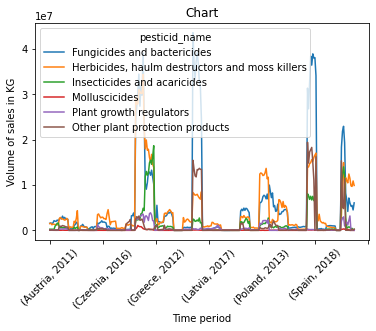

In [240]:
p_df.plot()
plt.xticks(rotation = 45)
plt.title("Chart")
plt.xlabel('Time period')
plt.ylabel('Volume of sales in KG')
plt.show()

In [241]:
pd.options.display.float_format = '{:,.2f}'.format
p_df.corr()

pesticid_name,Fungicides and bactericides,"Herbicides, haulm destructors and moss killers",Insecticides and acaricides,Molluscicides,Plant growth regulators,Other plant protection products
pesticid_name,,,,,,
Fungicides and bactericides,1.00,0.76,0.54,0.58,0.43,0.81
"Herbicides, haulm destructors and moss killers",0.76,1.00,0.60,0.79,0.81,0.37
Insecticides and acaricides,0.54,0.60,1.00,0.42,0.65,0.40
Molluscicides,0.58,0.79,0.42,1.00,0.69,0.23
Plant growth regulators,0.43,0.81,0.65,0.69,1.00,0.06
Other plant protection products,0.81,0.37,0.40,0.23,0.06,1.00


In [242]:
proportion_train_test = 0.7
l = int(proportion_train_test * len(p_df))
col = p_df.columns

In [243]:
X_train, X_test, y_train, y_test = train_test_split(p_df[col[1:]], p_df[col[0]], test_size=0.3, shuffle=False)

In [244]:
print('X_train', X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (201, 5)
X_test (87, 5)
y_train (201,)
y_test (87,)


In [245]:
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

In [246]:
y_pred_test = lin_model.predict(X_test)
y_pred_train = lin_model.predict(X_train)

In [247]:
print("Score train :", lin_model.score(X_train, y_train))
print("Score test :", lin_model.score(X_test, y_test))
print("Coefficients :", lin_model.coef_)
for s in zip(col[1:], lin_model.coef_):
    print(s[0], ":", s[1])
print("Intercept :", lin_model.intercept_)
print("Mean absolute error (train) :", metrics.mean_absolute_error(y_train, y_pred_train))
print("Mean absolute error (test) :", metrics.mean_absolute_error(y_test, y_pred_test))
print("Mean Squared Error (train) :", metrics.mean_squared_error(y_train, y_pred_train))
print("Mean Squared error (test) :", metrics.mean_squared_error(y_test, y_pred_test))
print("Root Mean Squared Error (train) :", np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print("Root Mean Squared error (test) :", np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Score train : 0.9625862760904372
Score test : 0.6888681049525144
Coefficients : [ 0.79232453  0.14383752  7.98578085 -1.58666929  2.12375616]
Herbicides, haulm destructors and moss killers : 0.7923245331894007
Insecticides and acaricides : 0.14383751668946268
Molluscicides : 7.985780854705393
Plant growth regulators : -1.5866692946920815
Other plant protection products : 2.1237561641699867
Intercept : -188738.78613399155
Mean absolute error (train) : 1032241.3884064513
Mean absolute error (test) : 2720115.1020331937
Mean Squared Error (train) : 3225638565885.0356
Mean Squared error (test) : 34849571028214.46
Root Mean Squared Error (train) : 1796006.2822509937
Root Mean Squared error (test) : 5903352.524474077


In [248]:
model = sm.OLS(y_train, X_train)
results = model.fit()
y_pred_test_OLS = results.predict(X_test)
y_pred_train_OLS = results.predict(X_train)
print(results.summary())

                                     OLS Regression Results                                     
Dep. Variable:     Fungicides and bactericides   R-squared (uncentered):                   0.970
Model:                                     OLS   Adj. R-squared (uncentered):              0.969
Method:                          Least Squares   F-statistic:                              1248.
Date:                         Tue, 04 Apr 2023   Prob (F-statistic):                   1.74e-146
Time:                                 13:39:56   Log-Likelihood:                         -3180.6
No. Observations:                          201   AIC:                                      6371.
Df Residuals:                              196   BIC:                                      6388.
Df Model:                                    5                                                  
Covariance Type:                     nonrobust                                                  
                              

In [249]:
print('coefficient of determination:', results.rsquared)
print('adjusted coefficient of determination:', results.rsquared_adj)
print('regression coefficients:', results.params, sep = '\n')

coefficient of determination: 0.9695510214809883
adjusted coefficient of determination: 0.968774261824891
regression coefficients:
Herbicides, haulm destructors and moss killers    0.77
Insecticides and acaricides                       0.15
Molluscicides                                     8.67
Plant growth regulators                          -1.64
Other plant protection products                   2.12
dtype: float64


In [250]:
df_test = pd.DataFrame({'Actual_test': y_test, 'Predicted_test': y_pred_test, 'Predicted_test_OLS':y_pred_test_OLS})
df_train = pd.DataFrame({'Actual train': y_train, 'Predicted_train': y_pred_train, 'Predicted_train_OLS': y_pred_train_OLS})
df_result = df_train.join(df_test, how = 'outer')
df_result

Actual train  Predicted_train  \
country_name   TIME_PERIOD                                  
Austria        2011         1,544,218.00     1,335,677.58   
               2012         1,634,371.00     1,243,499.21   
               2013         1,492,799.00     1,024,288.82   
               2014         1,641,055.00     1,078,618.07   
               2015         2,130,973.00     1,036,544.55   
...                                  ...              ...   
United Kingdom 2015                  NaN              NaN   
               2016                  NaN              NaN   
               2017                  NaN              NaN   
               2018                  NaN              NaN   
               2019                  NaN              NaN   

                            Predicted_train_OLS  Actual_test  Predicted_test  \
country_name   TIME_PERIOD                                                     
Austria        2011                1,516,917.57          NaN             NaN   
               2012                1,416,984.06          NaN             NaN   
               2013                1,197,669.29          NaN             NaN   
               2014                1,250,880.79          NaN             NaN   
               2015                1,212,244.93          NaN             NaN   
...                                         ...          ...             ...   
United Kingdom 2015                         NaN 6,032,359.00    3,957,038.46   
               2016                         NaN 5,330,003.00    7,634,222.77   
               2017                         NaN 5,484,053.00    8,119,198.28   
               2018                         NaN 4,492,460.00    8,460,127.02   
               2019                         NaN 6,056,984.00    8,221,924.85   

                            Predicted_test_OLS  
country_name   TIME_PERIOD                      
Austria        2011                        NaN  
               2012                        NaN  
               2013                        NaN  
               2014                        NaN  
               2015                        NaN  
...                                        ...  
United Kingdom 2015               3,768,210.15  
               2016               7,637,855.95  
               2017               8,123,750.43  
               2018               8,441,275.87  
               2019               8,220,913.23  

[288 rows x 6 columns]

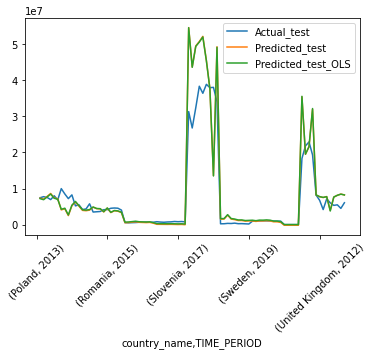

In [251]:
df_result[['Actual_test', 'Predicted_test','Predicted_test_OLS']].plot()
plt.xticks(rotation=45)
plt.show()

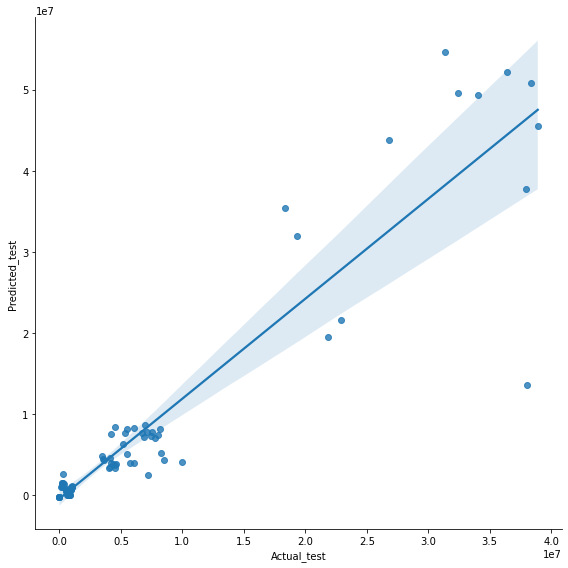

In [252]:
sns.pairplot(df_test, x_vars = ['Actual_test'], y_vars = 'Predicted_test', kind = 'reg', height = 8)
plt.show()

linear model for the above data and the hypothesis provides bad forecast quality. 
So build a non linear model based on neural network to check the forecast quality.

multi layer perceptron with 2 hidden layers

using sklearn MLPRegressor

In [253]:
model = MLPRegressor(random_state = 42, max_iter =500)
model.fit(X_train, y_train)
y_pred_train_MLP = model.predict(X_train)
y_pred_test_MLP = model.predict(X_test)

In [254]:
print("Score train :", model.score(X_train, y_train))
print("Score test :", model.score(X_test, y_test))

print("Mean absolute error (train) :", metrics.mean_absolute_error(y_train, y_pred_train))
print("Mean absolute error (test) :", metrics.mean_absolute_error(y_test, y_pred_test))
print("Mean Squared Error (train) :", metrics.mean_squared_error(y_train, y_pred_train))
print("Mean Squared error (test) :", metrics.mean_squared_error(y_test, y_pred_test))
print("Root Mean Squared Error (train) :", np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
print("Root Mean Squared error (test) :", np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))

Score train : 0.9446782790734168
Score test : 0.8084244535845815
Mean absolute error (train) : 1032241.3884064513
Mean absolute error (test) : 2720115.1020331937
Mean Squared Error (train) : 3225638565885.0356
Mean Squared error (test) : 34849571028214.46
Root Mean Squared Error (train) : 1796006.2822509937
Root Mean Squared error (test) : 5903352.524474077


before using keras, normalize the data

In [255]:
scaler_X_train = MinMaxScaler(feature_range = (0,1))
scaler_y_train = MinMaxScaler(feature_range = (0,1))
scaler_X_test = MinMaxScaler(feature_range=(0,1))
scaler_y_test = MinMaxScaler(feature_range=(0,1))

scaled_X_train = scaler_X_train.fit_transform(X_train.astype('float64'))
scaled_y_train = scaler_y_train.fit_transform(y_train.astype('float64').values.reshape(-1,1))
scaled_X_test = scaler_X_test.fit_transform(X_test.astype('float64'))
scaled_y_test = scaler_y_test.fit_transform(y_test.astype('float64').values.reshape(-1,1))

In [256]:
def BP_model(X):
    model = Sequential()
    model.add(Dense(100, input_dim=X.shape[1], 
                    kernel_initializer = 'normal', 
                    activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(100, kernel_initializer = 'normal',
                   activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, kernel_initializer = 'normal'))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    return model

In [257]:
epochs = 10
batch_size = int(y_train.shape[0]*.1)
estimator = KerasRegressor(build_fn=BP_model, X = scaled_X_train, epochs = epochs, batch_size = batch_size, verbose = 0)

C:\Users\ADMIN\AppData\Local\Temp/ipykernel_13552/2199961100.py:3: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=BP_model, X = scaled_X_train, epochs = epochs, batch_size = batch_size, verbose = 0)


In [258]:
history=estimator.fit(scaled_X_train, scaled_y_train, validation_data=(scaled_X_test, scaled_y_test))

In [259]:
fitting = True
fitting_save = True


import pickle

if fitting:
    history=estimator.fit(scaled_X_train, scaled_y_train, validation_data=(scaled_X_test, scaled_y_test))
    if fitting_save:
        estimator.model.save('BP_saved_model.h5')
        print("Saved model to disk")
        with open('history.pickle', 'wb') as f:
            pickle.dump(history.history, f)
# load model 
from keras.models import load_model

# Instantiate the model as you please (we are not going to use this)
estimator = KerasRegressor(build_fn=BP_model, X=scaled_X_train, epochs=epochs, batch_size=batch_size, verbose=0)
# This is where you load the actual saved model into a new variable.
estimator.model = load_model('BP_saved_model.h5')    
with open('history.pickle', 'rb') as f:
    history = pickle.load(f)
print("Loaded model from disk")

Saved model to disk
Loaded model from disk


C:\Users\ADMIN\AppData\Local\Temp/ipykernel_13552/3166226470.py:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasRegressor(build_fn=BP_model, X=scaled_X_train, epochs=epochs, batch_size=batch_size, verbose=0)


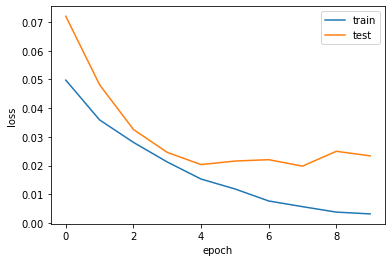

In [260]:
plt.figure()
plt.plot(history['loss'], label = 'train')
plt.plot(history['val_loss'], label = 'test')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [261]:
res_train = estimator.predict(scaled_X_train)
res_test = estimator.predict(scaled_X_test)
res_train_ANN = scaler_y_train.inverse_transform(res_train.reshape(-1,1)).flatten()
res_test_ANN =scaler_y_test.inverse_transform(res_test.reshape(-1,1)).flatten()

In [262]:
print("Correlation train", model.score(X_train, res_train_ANN))
print("Correlation test", model.score(X_test, res_test_ANN))

print('Mean Absolute Error (train):', metrics.mean_absolute_error(y_train, res_train_ANN))
print('Mean Absolute Error (test):', metrics.mean_absolute_error(y_test, res_test_ANN))
print('Mean Squared Error (train):', metrics.mean_squared_error(y_train, res_train_ANN))
print('Mean Squared Error (test):', metrics.mean_squared_error(y_test, res_test_ANN))
print('Root Mean Squared Error (train):', np.sqrt(metrics.mean_squared_error(y_train, res_train_ANN)))
print('Root Mean Squared Error (test):', np.sqrt(metrics.mean_squared_error(y_test, res_test_ANN)))

Correlation train 0.9769572105060146
Correlation test 0.9322617303723213
Mean Absolute Error (train): 980947.8854166666
Mean Absolute Error (test): 3767156.4960488505
Mean Squared Error (train): 3279570991267.8022
Mean Squared Error (test): 35425042755723.63
Root Mean Squared Error (train): 1810958.5835318826
Root Mean Squared Error (test): 5951894.0477568675


In [264]:
df_test = pd.DataFrame({'Actual_test':y_test, 'Predicted_test': y_pred_test, 'Predicted_test_MLP': y_pred_test_MLP, 'Predicted_test_ANN': res_test_ANN})
df_train = pd.DataFrame({'Actual_train':y_train, 'Predicted_train': y_pred_train, 'Predicted_train_MLP': y_pred_train_MLP, 'Predicted_train_ANN': res_train_ANN})
df_res = df_train.join(df_test, how = 'outer')
df_res

Actual_train  Predicted_train  \
country_name   TIME_PERIOD                                  
Austria        2011         1,544,218.00     1,335,677.58   
               2012         1,634,371.00     1,243,499.21   
               2013         1,492,799.00     1,024,288.82   
               2014         1,641,055.00     1,078,618.07   
               2015         2,130,973.00     1,036,544.55   
...                                  ...              ...   
United Kingdom 2015                  NaN              NaN   
               2016                  NaN              NaN   
               2017                  NaN              NaN   
               2018                  NaN              NaN   
               2019                  NaN              NaN   

                            Predicted_train_MLP  Predicted_train_ANN  \
country_name   TIME_PERIOD                                             
Austria        2011                1,232,708.74         1,095,240.38   
               2012                1,226,787.98           993,616.25   
               2013                1,046,969.30           864,146.12   
               2014                1,100,759.33           887,305.50   
               2015                1,060,091.41           872,292.88   
...                                         ...                  ...   
United Kingdom 2015                         NaN                  NaN   
               2016                         NaN                  NaN   
               2017                         NaN                  NaN   
               2018                         NaN                  NaN   
               2019                         NaN                  NaN   

                            Actual_test  Predicted_test  Predicted_test_MLP  \
country_name   TIME_PERIOD                                                    
Austria        2011                 NaN             NaN                 NaN   
               2012                 NaN             NaN                 NaN   
               2013                 NaN             NaN                 NaN   
               2014                 NaN             NaN                 NaN   
               2015                 NaN             NaN                 NaN   
...                                 ...             ...                 ...   
United Kingdom 2015        6,032,359.00    3,957,038.46        8,755,247.49   
               2016        5,330,003.00    7,634,222.77        7,188,145.70   
               2017        5,484,053.00    8,119,198.28        7,512,683.56   
               2018        4,492,460.00    8,460,127.02        7,989,058.45   
               2019        6,056,984.00    8,221,924.85        7,647,681.46   

                            Predicted_test_ANN  
country_name   TIME_PERIOD                      
Austria        2011                        NaN  
               2012                        NaN  
               2013                        NaN  
               2014                        NaN  
               2015                        NaN  
...                                        ...  
United Kingdom 2015              11,280,799.00  
               2016              11,826,612.00  
               2017              12,042,344.00  
               2018              13,120,412.00  
               2019              12,237,037.00  

[288 rows x 8 columns]

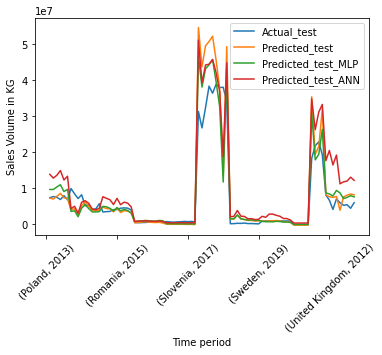

In [266]:
df_res[['Actual_test', 'Predicted_test', 'Predicted_test_MLP', 'Predicted_test_ANN',]].plot()
plt.xticks(rotation=45)
plt.xlabel("Time period")
plt.ylabel("Sales Volume in KG")
plt.show()

ANN shows better results than Linear Regression in this case.